# The demonstration of the tropical precipitation module in detailes

# Structure


 1. [Load of](#1-load-of-packages-modules-and-data)

    1.1. [packages](#11-loading-the-necessary-packages)

    1.2. [modules and](#12-loading-the-written-modules)

    1.3. [data with the use of aqua package](#13-loading-the-data-with-the-use-of-aqua-package)

2. [Initialization of precipitation diagnostic and setting the class attributes](#2-initializing-the-class-object-and-setting-the-class-attributes)

3. [Illustration of some preprocessing possibilities of precipitation diagnostic, such as](#3-illustation-of-some-preprocessing-possibilietes-of-precipitation-diagnostic)

    3.1. [Selection of tropical latitudes](#32-selection-of-tropical-latitudes)

4. [Calculation of histogram of precipitation/tropical precipitation](#4-calculation-of-histogram-of-precipitationtropicalprecipitation)

    4.1. [with manual data preprocessing](#41-diagnostic-with-manual-data-preprocessing)

    4.2 [automatic data preprocessing](#42-diagnostic-with-automatic-data-preprocessing)

    4.3. [with non uniform binning](#43-histogram-with-not-uniform-binning)
    
5. [Calculation time expectation for a total dataset](#5-expected-calculation-time-for-entire-dataset)
 
6. [Creation of graphics with a graphic module](#6-creation-of-graphics)

    6.1. [Creation of images](#61-images)
    
    6.2. [Creation of animation](#62-animation)

    6.3  [Creation of images of high and low resolution](#63-images-with-the-regrided-the-coordinates)

[Go to the end of file](#the-end)

#

## 1. Load of  packages, modules and data

### 1.1. Loading the necessary packages

In [1]:
#import dask
import re
import os
import importlib
import timeit
import sys
import numpy as np
#import xarray

#### Storing the absolute path of the current repository into the variable

In [2]:
with os.popen("pwd ") as f:
    _pwd = f.readline()

pwd = re.split(r'[\n]', _pwd)[0]

#### Setting the path to the diagnostic repository 

In [3]:
sys.path.append(str(pwd)+'/../')

import src.tr_pr_module
import src.time_functions
import src.graphic_creator
import src.slurm_job

### 1.2. Loading the written modules

#### Loading the tropical precipitation module

In [4]:
importlib.reload(src.tr_pr_module)
from  src.tr_pr_module import  xarray_attribute_update, data_size, TR_PR_Diagnostic

#### Loading the extra functions, which can be used in any diagnostic

In [5]:
importlib.reload(src.time_functions)
from  src.time_functions import time_interpreter, estimated_total_calc_time, optimal_amount_of_timesteps, time_regrider

importlib.reload(src.graphic_creator)
from src.graphic_creator import  animation_creator, image_creator, lon_lat_regrider

importlib.reload(src.slurm_job)
from  src.slurm_job import  slurm_interactive_job, squeue_user, scancel

#### Activating the slurm job if it is necessary 

In [ ]:
slurm_interactive_job()

In [11]:
squeue_user()

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           4771162   compute dask-wor  b382267 CG    1:50:03      1 l10103
           4772293   compute dask-wor  b382267  R       0:16      1 l20530


0

#### Importing the aqua module

In [12]:
import aqua
from aqua import Reader
from aqua.reader import catalogue

In [14]:
configdir = '../../../config/'
diagname  = 'tr_pr'
machine   = 'levante'
catalogue(configdir=configdir)

levante:
  args:
    path: ../../../config//levante/catalog.yaml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


### 1.3. Loading the data with the use of aqua package

#### IFS data

In [15]:
reader = Reader(model="IFS", exp="tco3999-ng5", source="ICMGG_atm2d",configdir=configdir, regrid="r200")
IFS = reader.retrieve()

In [ ]:
IFS

#### Regriding the small part/chunk of dataset for tests

In [16]:
IFS_chunk_regrided = reader.regrid(IFS["tprate"][10:30,:])

In [ ]:
IFS_chunk_regrided 

## 2. Initializing the class object and setting the class attributes

In [17]:
diag = TR_PR_Diagnostic()

diag.num_of_bins    = 15
diag.first_edge     = 0
diag.width_of_bin   = 1*10**(-4)/diag.num_of_bins
diag.bins           = None


diag.trop_lat = 10

# time related attributes 
diag.s_time     = None
diag.f_time     = None
diag.s_year     = None
diag.f_year     = None 
diag.s_month    = None
diag.f_month    = None 

#### User can put specify all attributes during initialization of class object 

In [453]:
diag = TR_PR_Diagnostic(num_of_bins = 15, first_edge = 0, width_of_bin = 1*10**(-6)/15)

#### Attributes of the class can be updated in two ways

In [81]:
print(diag.num_of_bins)
diag.num_of_bins = 30
print(diag.num_of_bins)

15
30


#### OR

In [82]:
print(diag.num_of_bins)
diag.class_attributes_update(num_of_bins = 20, first_edge = 0, width_of_bin = 1*10**(-6)/20)
print(diag.num_of_bins)

30
20


## 3. Illustration of some preprocessing possibilities of precipitation diagnostic

#### We may want to pass the attributes of entire dataset into our regrided chunk of data. (Also, sum the `history` of datasets) 

In [89]:
IFS_chunk_regrided = xarray_attribute_update(IFS_chunk_regrided, IFS)

#### Units of precepitation rate

In [90]:
IFS_chunk_regrided.attrs['units']

'm s**-1'

### 3.1 Selection of tropical latitudes

In [23]:
IFS_chunk_regrided = IFS_chunk_regrided.compute()
IFS_chunk_regrided_trop = diag.ds_per_lat_range(IFS_chunk_regrided)

In [24]:
IFS_chunk_regrided_trop

<xarray.DataArray 'tprate' (time: 5, lat: 10, lon: 180)>
dask.array<where, shape=(5, 10, 180), dtype=float64, chunksize=(1, 10, 180), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T10:00:00 ... 2020-01-20T14:00:00
  * lat      (lat) float64 -9.0 -7.0 -5.0 -3.0 -1.0 1.0 3.0 5.0 7.0 9.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Attributes: (12/24)
    paramId:                    172228
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    factor:                     0.0002777777777777778
    offset:                     0
    decumulated:                1
    src_units:                  m
    units_fixed:                1
    regridded:                  1

#### We can modify the selected tropical area as 

In [ ]:
diag.trop_lat = 25

IFS_chunk_regrided_trop = diag.ds_per_lat_range(IFS_chunk_regrided)

#### OR 

In [91]:
IFS_chunk_regrided_trop = diag.ds_per_lat_range(IFS_chunk_regrided, trop_lat = 10)

## 4. Calculation of histogram of precipitation/tropicalprecipitation


### 4.1. Diagnostic with manual data preprocessing

### Fastest histogram

In [191]:
hist_IFS  = diag.hist1d_fast(IFS_chunk_regrided,  preprocess = False)
hist_IFS

<xarray.DataArray (bin: 15)>
array([7.3648e+04, 2.9230e+03, 1.3840e+03, 8.4800e+02, 5.3300e+02,
       4.0500e+02, 2.8000e+02, 2.0600e+02, 1.8000e+02, 1.1500e+02,
       1.0500e+02, 8.3000e+01, 6.1000e+01, 3.9000e+01, 5.3000e+01])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 8e-07 8.667e-07 9.333e-07
Attributes: (12/28)
    paramId:                    172228
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    units_fixed:                1
    regridded:                  1
    edition:                    1
    centre:                     ecmf
    centreDescription:          European Centre for Medium-Range Weather Fore...
    subCentre:                  0

#### Only for tropical area

In [192]:
hist_IFS_trop  = diag.hist1d_fast(IFS_chunk_regrided_trop,  preprocess = False)
hist_IFS_trop

<xarray.DataArray (bin: 15)>
array([7.302e+03, 5.970e+02, 2.940e+02, 2.290e+02, 1.450e+02, 1.130e+02,
       7.900e+01, 5.700e+01, 5.500e+01, 3.800e+01, 2.800e+01, 1.400e+01,
       1.200e+01, 7.000e+00, 6.000e+00])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 8e-07 8.667e-07 9.333e-07
Attributes: (12/28)
    paramId:                    172228
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    units_fixed:                1
    regridded:                  1
    edition:                    1
    centre:                     ecmf
    centreDescription:          European Centre for Medium-Range Weather Fore...
    subCentre:                  0

## 4.2. Diagnostic with automatic data preprocessing

In [50]:
diag = TR_PR_Diagnostic()

# mandatory attributes
diag.num_of_bins = 15
diag.first_edge = 0
diag.width_of_bin = 1*10**(-4)/diag.num_of_bins

# other attributes of class whoch have a default value
diag.trop_lat = 10
diag.s_time = 10
diag.f_time = 20

#### OR

In [13]:
diag = TR_PR_Diagnostic(num_of_bins = 15, first_edge = 0, width_of_bin = 1*10**(-6)/15)

In [ ]:
IFS

In [51]:
hist_IFS_prepr  = diag.hist1d_fast(IFS, reader=reader, trop_lat = 10, s_time = 10,  f_time = 15)
hist_IFS_prepr 

<xarray.DataArray (bin: 15)>
array([9000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-06 1.333e-05 ... 8e-05 8.667e-05 9.333e-05
Attributes: (12/24)
    paramId:                    172228
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    factor:                     0.0002777777777777778
    offset:                     0
    decumulated:                1
    src_units:                  m
    units_fixed:                1
    regridded:                  1

In [15]:
hist_IFS_prepr  = diag.hist1d_fast(IFS, reader=reader, trop_lat = 10, s_month=3,  f_month=4)
hist_IFS_prepr 

In [ ]:
hist_IFS_prepr  = diag.hist1d_fast(IFS, reader=reader, trop_lat = 20,  s_time = '2020:01', f_time ='2020/03/20/12')
hist_IFS_prepr 

In [ ]:
hist_IFS_prepr  = diag.hist1d_fast(IFS, reader=reader, trop_lat = 10, s_time = '2020', f_time ='2020.03.20')
hist_IFS_prepr 

### 4.3. Histogram with not uniform binning

In [180]:
bins = np.logspace(-9, -6, 15)
bins

array([1.00000000e-09, 1.63789371e-09, 2.68269580e-09, 4.39397056e-09,
       7.19685673e-09, 1.17876863e-08, 1.93069773e-08, 3.16227766e-08,
       5.17947468e-08, 8.48342898e-08, 1.38949549e-07, 2.27584593e-07,
       3.72759372e-07, 6.10540230e-07, 1.00000000e-06])

In [156]:
diag = TR_PR_Diagnostic(bins = bins, s_time = 10, f_time = 80)

In [105]:
IFS_chunk_regrided_trop=IFS_chunk_regrided_trop.compute()

In [145]:
hist_IFS_trop_logspaced  = diag.hist1d_np(IFS_chunk_regrided_trop, preprocess=False, bins=bins)
hist_IFS_trop_logspaced

<xarray.DataArray (bin: 14)>
array([562, 741, 877, 896, 752, 529, 447, 442, 441, 406, 374, 342, 239,
        99])
Coordinates:
  * bin      (bin) float64 1e-09 1.638e-09 2.683e-09 ... 3.728e-07 6.105e-07
Attributes: (12/24)
    paramId:                    172228
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    factor:                     0.0002777777777777778
    offset:                     0
    decumulated:                1
    src_units:                  m
    units_fixed:                1
    regridded:                  1

In [57]:
hist_IFS_trop  = diag.hist1d_fast(IFS_chunk_regrided_trop,  preprocess = False, bins=bins)
hist_IFS_trop

<xarray.DataArray (bin: 15)>
array([7.24e+03, 5.91e+02, 3.08e+02, 2.33e+02, 1.47e+02, 1.20e+02,
       9.30e+01, 6.00e+01, 4.80e+01, 4.60e+01, 3.30e+01, 2.00e+01,
       1.40e+01, 1.00e+01, 7.00e+00])
Coordinates:
  * bin      (bin) float64 0.0 6.667e-08 1.333e-07 ... 8e-07 8.667e-07 9.333e-07
Attributes: (12/24)
    paramId:                    172228
    dataType:                   fc
    numberOfPoints:             64144000
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    factor:                     0.0002777777777777778
    offset:                     0
    decumulated:                1
    src_units:                  m
    units_fixed:                1
    regridded:                  1

## 5. Expected calculation time for entire dataset

In [218]:
time_interpreter(IFS)

'1H'

####  Checking the calculation time of a small chunk of the dataset

In [37]:
result = %timeit -r 2 -n 1 -o  diag.hist1d_fast(IFS_chunk_regrided_trop,  preprocess = False)
time_fast_reg, time_fast_reg_stdev =  result.average, result.stdev 

450 µs ± 72 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)


#### Estemated calculation time of entire dataset

In [39]:
estimated_total_calc_time(ds_part = IFS_chunk_regrided_trop, calc_time = time_fast_reg, ds_full = IFS,  units='D')

(86668.67938164828, 1.0031097150653736)

#### Optimal amount of timesteps

In [41]:
optimal_amount_of_timesteps(ds_part = IFS_chunk_regrided_trop, calc_time = time_fast_reg,  ds_full = IFS, wanted_time ='3H')

(0.12461249066045943, 673)

#

## 6. Creation of graphics 

### 6.1. Images

#### Plot of obtained histogram 

#### We can make plots of frequency histograms. We need to set `pdf` argument in `hist_plot` function to `False` 

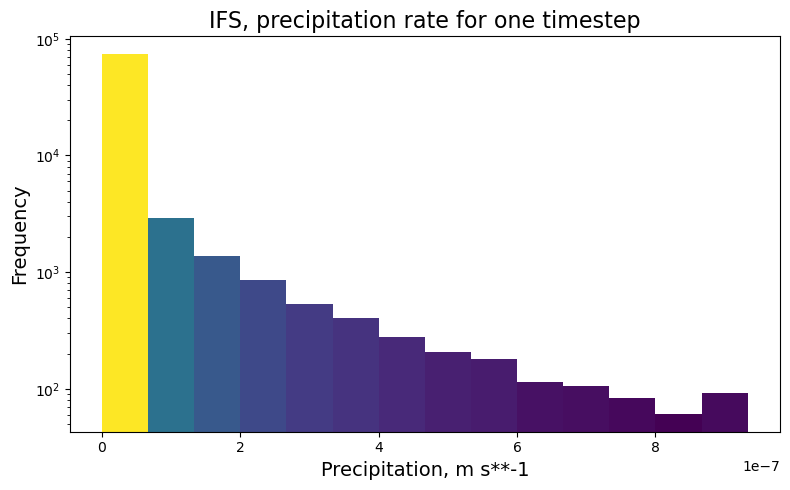

In [198]:
diag.hist_plot(hist_IFS, pdf = False, smooth = False, label='IFS/IFS', plot_title = "IFS, precipitation rate for one timestep")

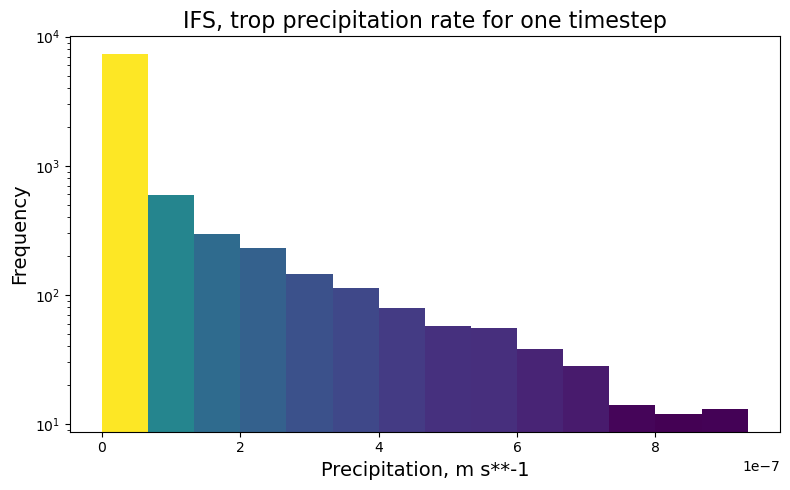

In [199]:
diag.hist_plot(hist_IFS_trop, pdf = False, smooth = False, label='IFS/IFS_trop', plot_title = "IFS, trop precipitation rate for one timestep")

#### Or we can create a pdf histogram by setting `pdf = True` in `hist_plot` function. (Default value of `pdf` is `True`)

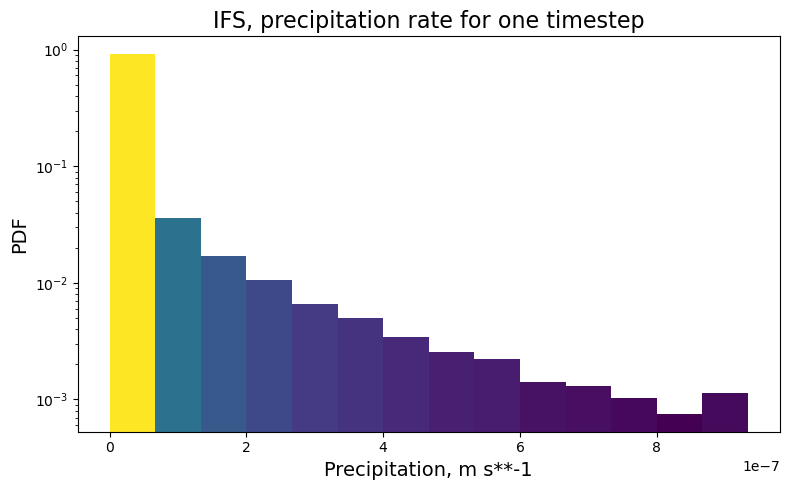

In [200]:
diag.hist_plot(hist_IFS, smooth = False, label='IFS/IFS', plot_title = "IFS, precipitation rate for one timestep")

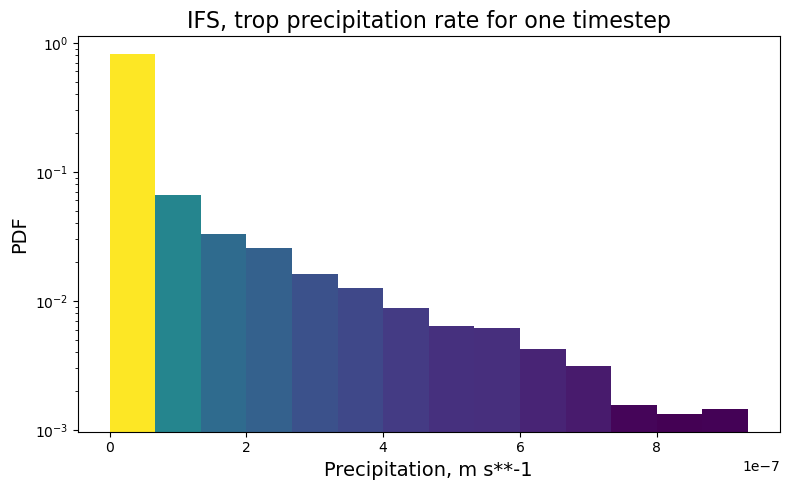

In [201]:
diag.hist_plot(hist_IFS_trop, pdf = True, smooth = False, label='IFS/IFS_trop', plot_title = "IFS, trop precipitation rate for one timestep")

#### We can also plot typical 2D dependence of counts versus the right edge of the bins by setting the `smooth = True.` It is also a default value.

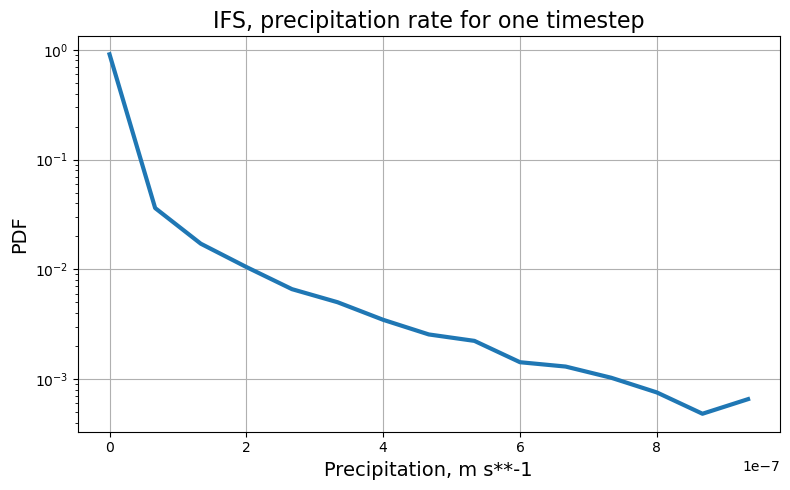

In [202]:
diag.hist_plot(hist_IFS, label='IFS/IFS', plot_title = "IFS, precipitation rate for one timestep")

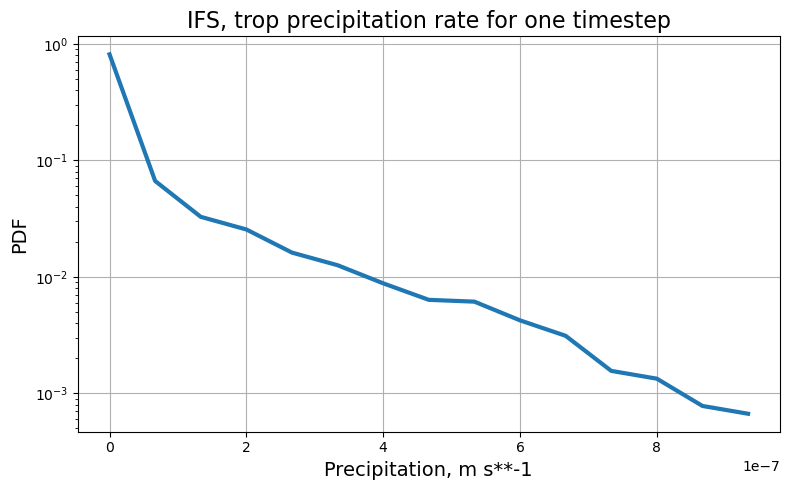

In [203]:
diag.hist_plot(hist_IFS_trop, pdf = True, smooth = True, label='IFS/IFS_trop', plot_title = "IFS, trop precipitation rate for one timestep")

### Histogram of logspaced binning. Argument `xlogscale=True` setting x-axe to the log scale. By default `xlogscale=False` 

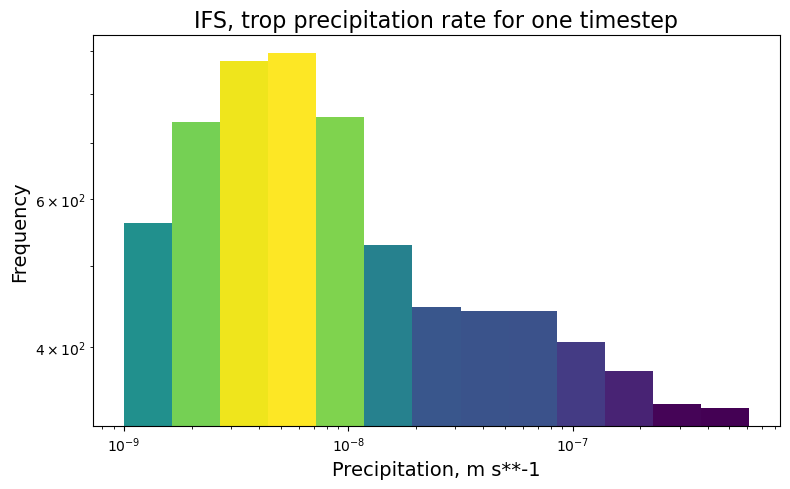

In [157]:
diag.hist_plot(hist_IFS_trop_logspaced, pdf = False, smooth = False, xlogscale=True, label='IFS/IFS_trop_log', plot_title = "IFS, trop precipitation rate for one timestep")

#### OR

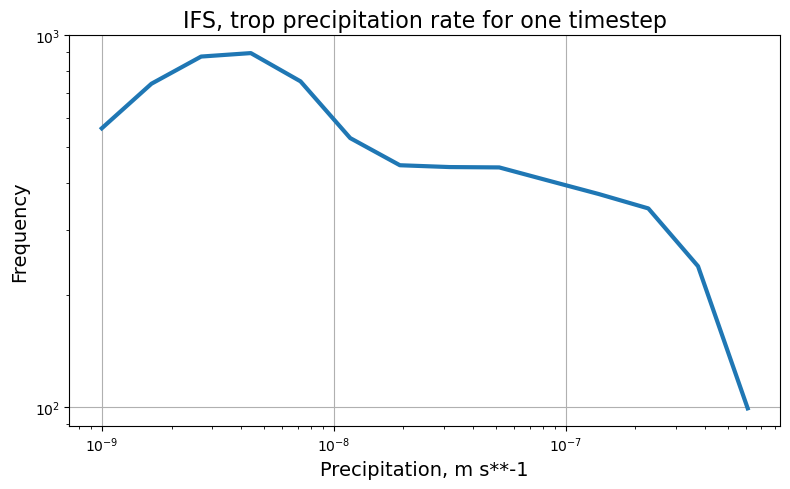

In [158]:
diag.hist_plot(hist_IFS_trop_logspaced, pdf = False, smooth = True, xlogscale=True, label='IFS/IFS_trop_log', plot_title = "IFS, trop precipitation rate for one timestep")

#### Plot of mean and median value of precipitation rate

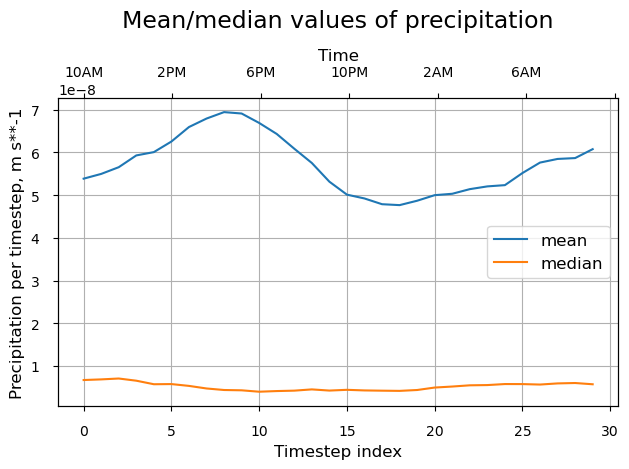

In [26]:
diag.mean_and_median_plot(IFS_chunk_regrided, savelabel = 'IFS/IFS')

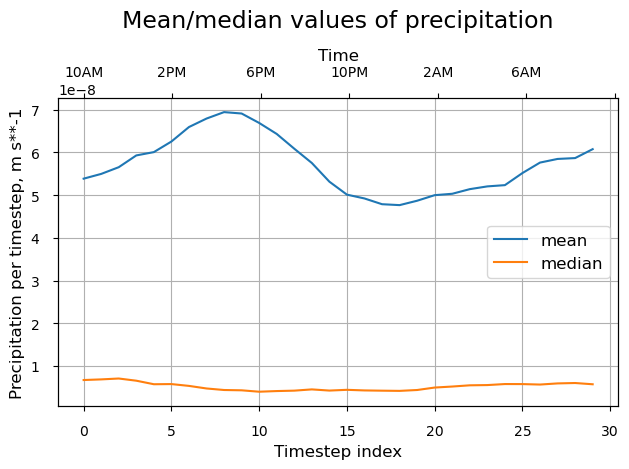

In [27]:
diag.mean_and_median_plot(IFS_chunk_regrided_trop, savelabel = 'IFS/IFS_trop')

#### Parameter plots

In [224]:
IFS_chunk_regrided = IFS_chunk_regrided.compute()

Done!


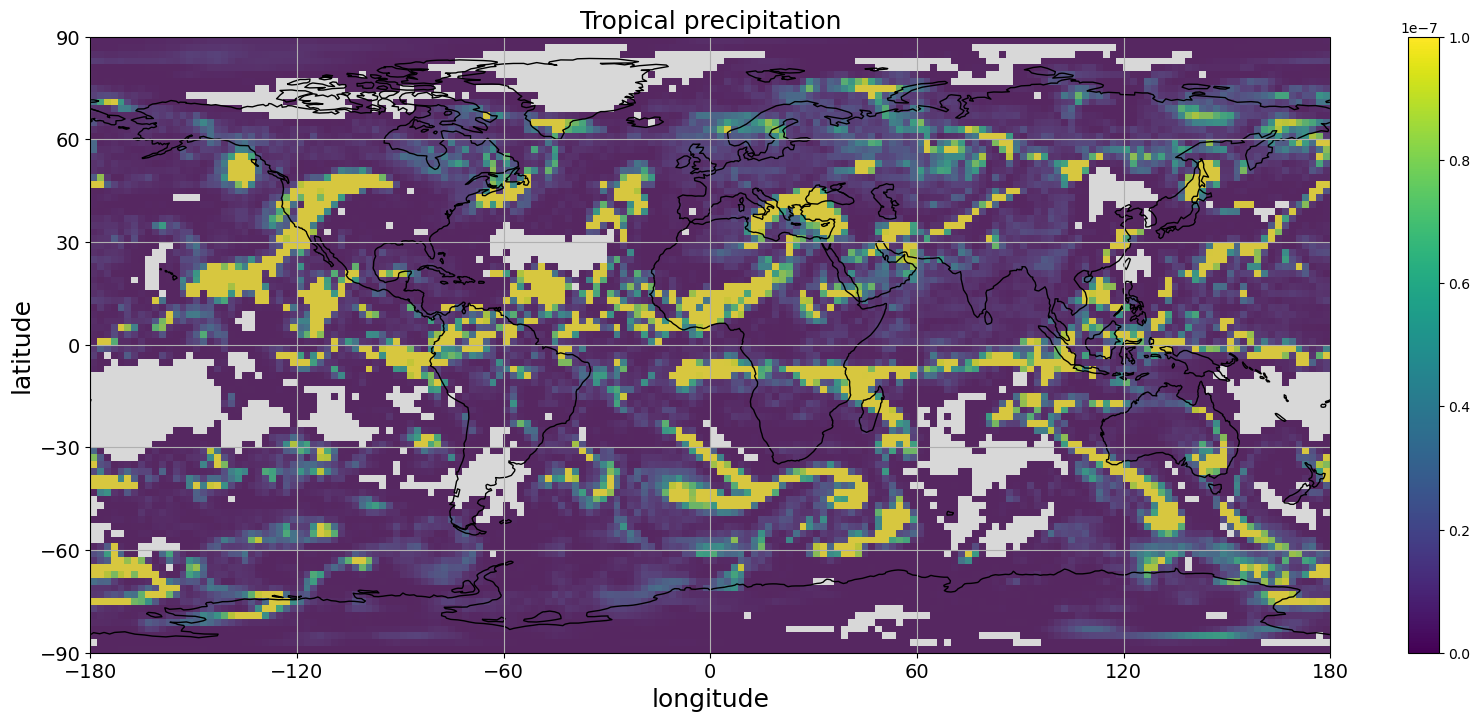

In [225]:
image_creator(IFS_chunk_regrided, vmin =0, vmax = 10**(-7),  trop_lat = 90,  label='IFS/IFS')

In [227]:
IFS_chunk_regrided_trop = IFS_chunk_regrided_trop.compute()

Done!


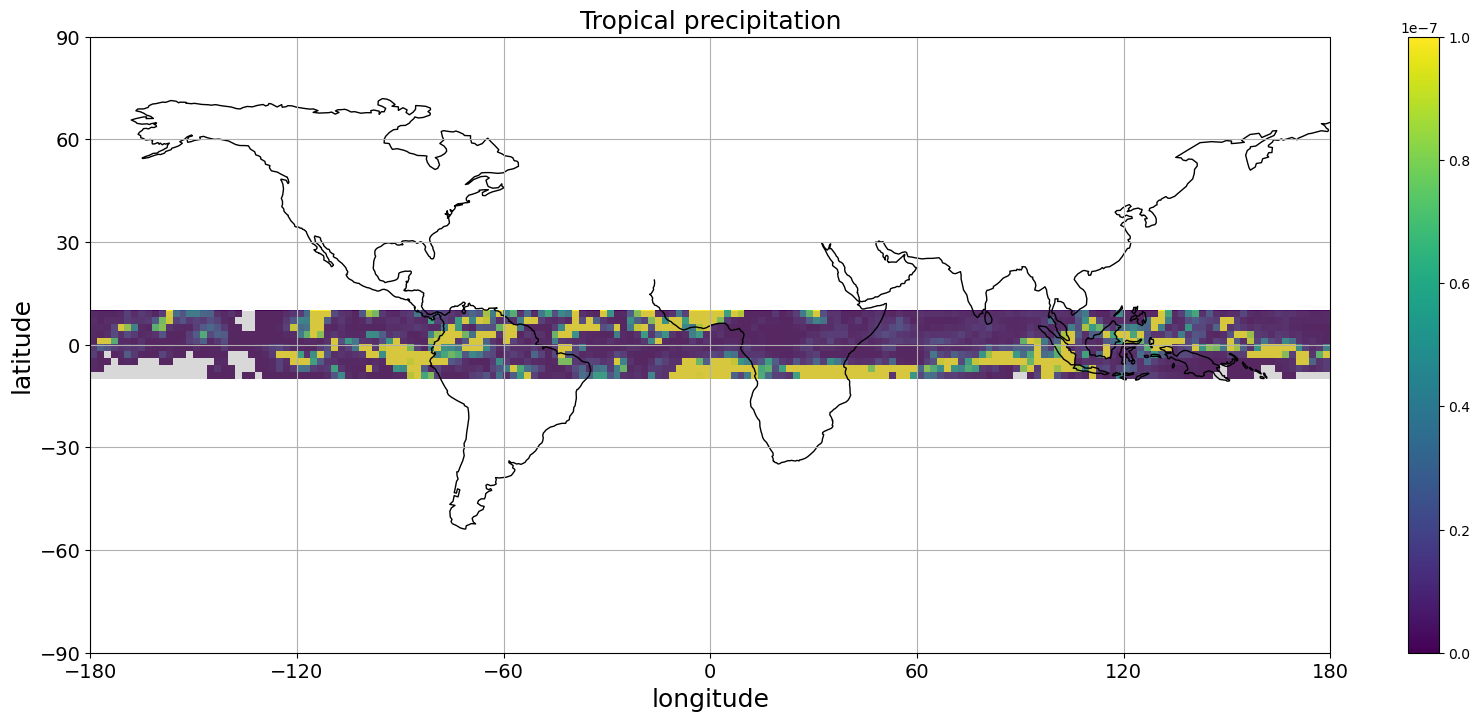

In [228]:
image_creator(IFS_chunk_regrided_trop, vmin =0, vmax = 10**(-7),  label='IFS/IFS_trop')

#

### 6.2. Animation

In [22]:
IFS_chunk_regrided = reader.regrid(IFS["tprate"][10:40,:])
IFS_chunk_regrided = IFS_chunk_regrided.compute()

.....................Done!


True

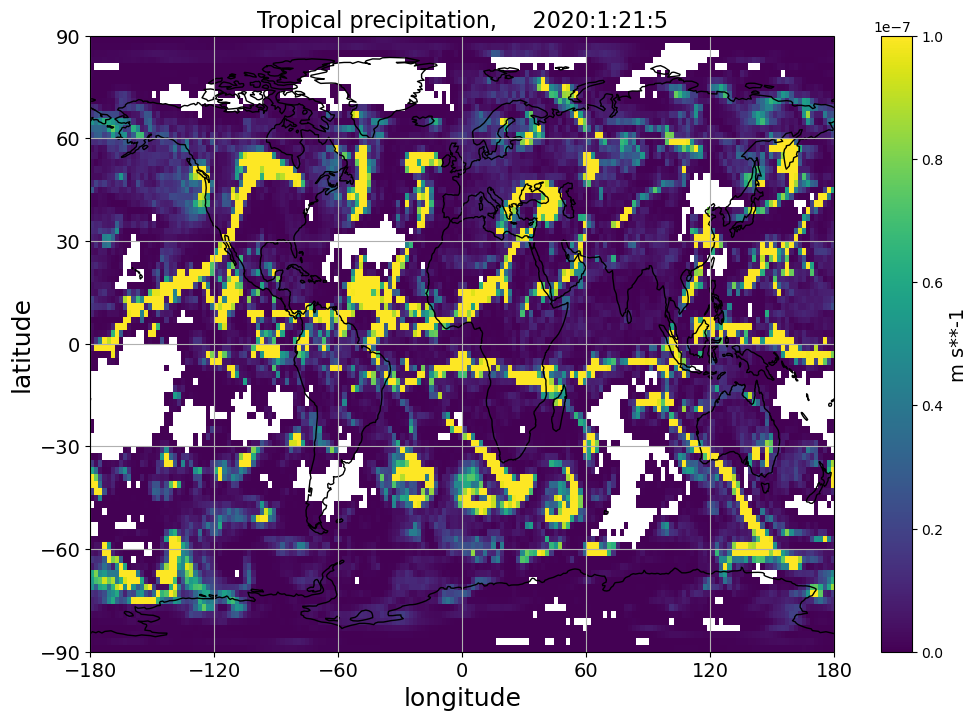

In [23]:
animation_creator(IFS_chunk_regrided, vmin =0, vmax = 10**(-7),   nSeconds = 20,  trop_lat = 90,  label='IFS_tprate')

In [24]:
IFS_chunk_regrided_trop = diag.ds_per_lat_range(IFS_chunk_regrided)
IFS_chunk_regrided_trop = IFS_chunk_regrided_trop.compute()

.....................Done!


True

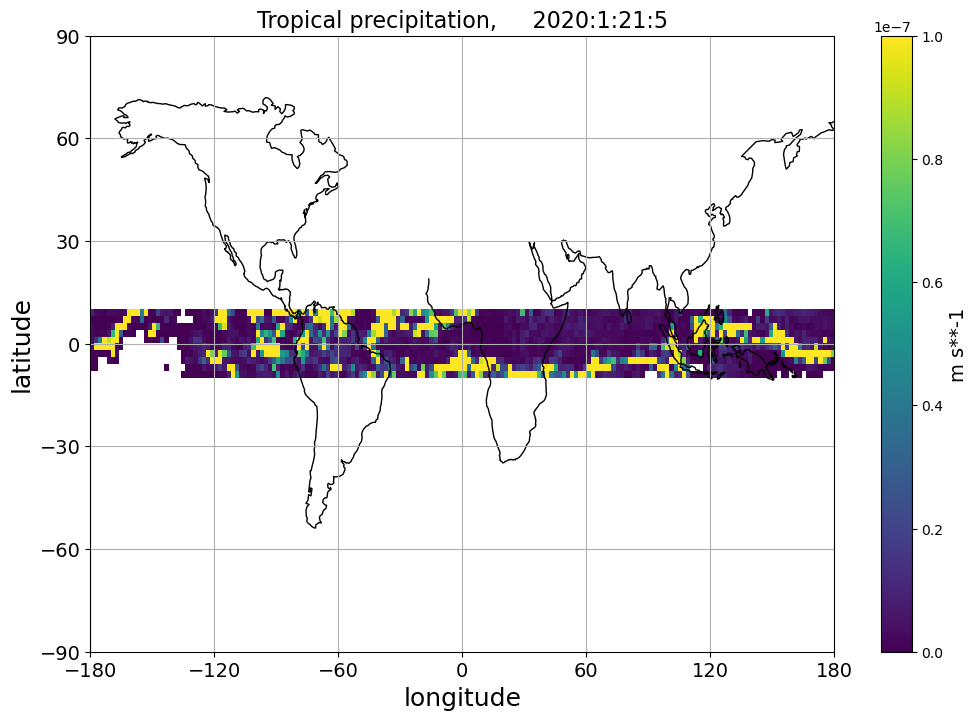

In [25]:
animation_creator(IFS_chunk_regrided_trop, vmin =0, vmax = 10**(-7), nSeconds = 20,  trop_lat = 10,  label='IFS_tprate_trop')

[Back to the top of file](#structure)

#

## 6.3 Images with the regrided the coordinates (high and low resolution)

### 6.3.1.Time regriding

In [ ]:
IFS_chunk_regrided_trop

In [ ]:
time_regrider(IFS_chunk_regrided_trop, timestep = -3)

In [ ]:
time_regrider(IFS_chunk_regrided_trop, new_time_unit='2H')

In [17]:
IFS_chunk_regrided = IFS_chunk_regrided.compute()

### 6.3.2 Space regriding

#### Data regriding into high resolution

In [175]:
lat_high_res    = lon_lat_regrider(IFS_chunk_regrided, step = 20, coord_name = 'lat')
latlon_high_res  = lon_lat_regrider(lat_high_res, step = 20, coord_name='lon')

#### Data regriding into low resolution

In [ ]:
lat_low_res    = lon_lat_regrider(IFS_chunk_regrided, step = -10, coord_name = 'lat')
latlon_low_res  = lon_lat_regrider(lat_low_res, step = -10, coord_name='lon')

#### Original resolution

Done!


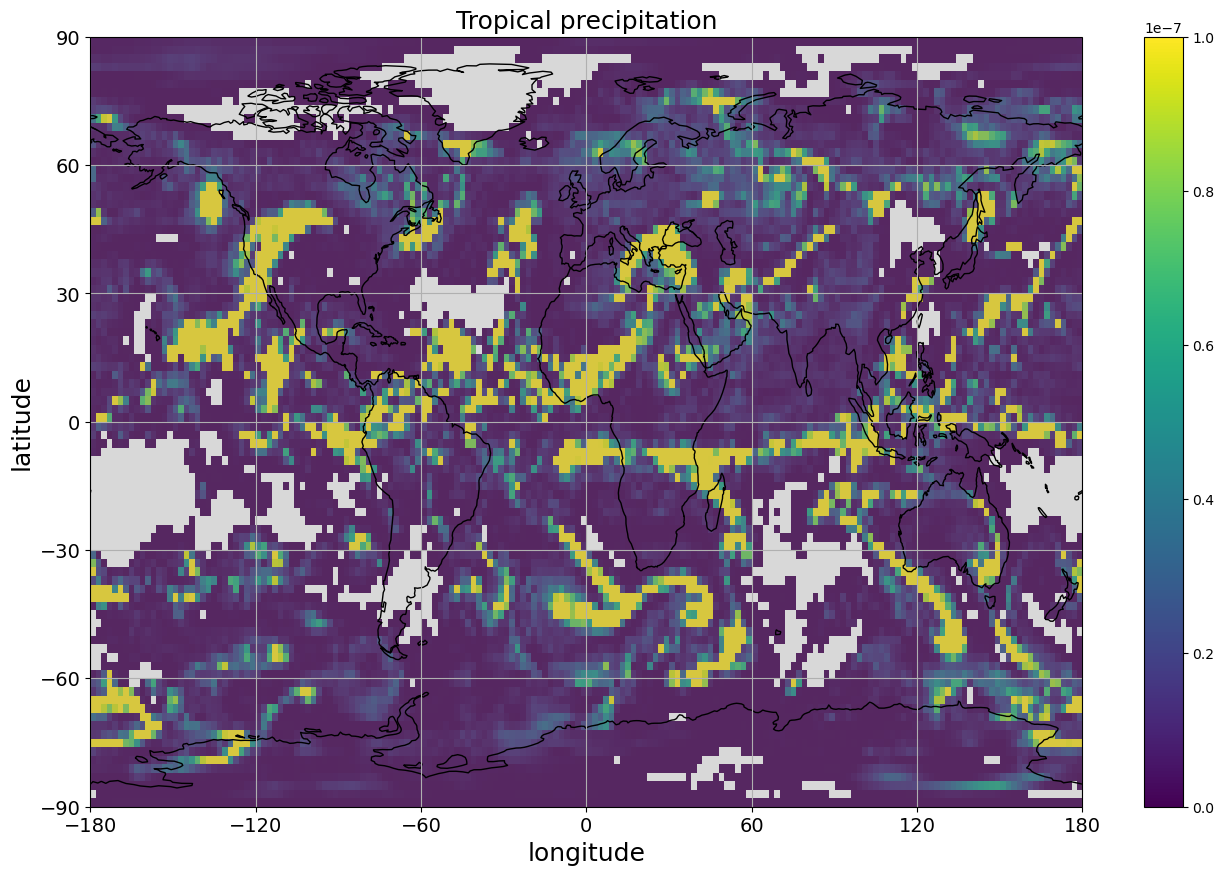

In [153]:
image_creator(IFS_chunk_regrided, vmin = 0, vmax = 10**(-7), figsize=2,  trop_lat = 90,  label='IFS/IFS_original')

#### High resolution

Done!


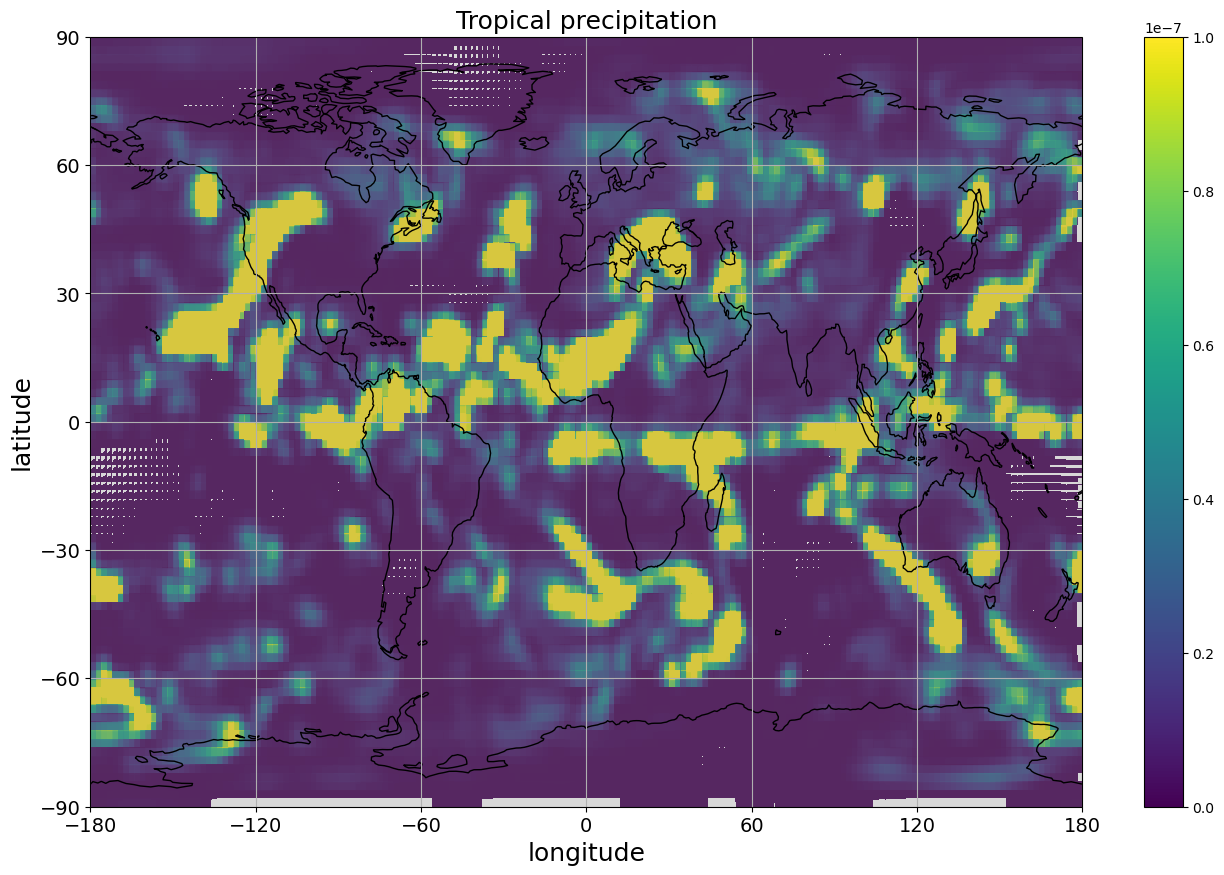

In [176]:
image_creator(latlon_high_res, vmin = 0, vmax = 10**(-7), figsize=2, trop_lat = 90,  label='IFS/IFS_regrided_highres') #

#### Low resolution

Done!


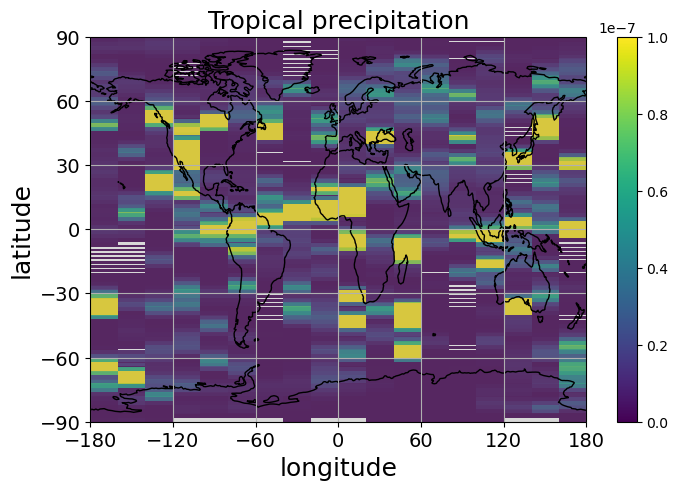

In [177]:
image_creator(latlon_low_res, vmin = 0, vmax = 10**(-7),  trop_lat = 90,  label='IFS/IFS_regrided_lowres') #

##### The end